# Time series forecasting

This notebook adapts the Tensorflow tutorial on [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series) to data generated from a model for epidemic processes. 

## Steps

1. Imports and setup
2. Load and prepare the generated data
3. Baseline forecasting
4. Univariate LSTM based forecasting
5. Multivariate LSTM based forecasting - Single Step
6. Multivariate LSTM based forecasting - Multiple Step

## Imports and setup

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Load and prepare the generated data

We load data from the ODE model introduced in the notebook "Probability and Information Theory". For each of the 150 virtuel outbreaks (randomized and with different model parameters), we have time series (with 500 steps) for four the variables "Susceptible", "Infected", "Recovered", and "Decased".

In [2]:
csv_path = "./data/epidemic_process_raw_data.csv"
df = pd.read_csv(csv_path)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
0,100.287149,103.541223,95.879814,96.354848,96.980932,97.855310,98.940537,100.187494,98.265709,95.307794,...,4.925236,4.922108,4.918981,4.915853,4.912726,4.950240,4.995291,5.040342,5.085393,5.130445
1,0.993774,1.017558,1.070030,1.116168,1.142078,1.134735,1.182418,1.272310,1.356565,1.438978,...,0.391775,0.384359,0.376942,0.369526,0.362109,0.356669,0.351595,0.346521,0.341447,0.336374
2,0.000000,0.017741,0.036585,0.054735,0.074266,0.096065,0.117691,0.139184,0.163615,0.189006,...,97.247764,96.062916,94.878068,93.693219,92.508371,92.617122,92.965783,93.314443,93.663103,94.011764
3,0.000000,0.000178,0.000364,0.000562,0.000757,0.000947,0.001160,0.001389,0.001635,0.001887,...,0.947347,0.950713,0.954079,0.957445,0.960811,0.959320,0.956929,0.954537,0.952146,0.949755
4,103.489688,100.282780,96.634270,98.532514,99.089272,97.440900,98.416534,101.404903,100.480758,98.277282,...,2.071958,2.064501,2.072213,2.090890,2.109567,2.128244,2.146921,2.165597,2.184274,2.202951


In [3]:
dfSusceptible = df[df.index % 4 == 0]
dfSusceptible.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
0,100.287149,103.541223,95.879814,96.354848,96.980932,97.855310,98.940537,100.187494,98.265709,95.307794,...,4.925236,4.922108,4.918981,4.915853,4.912726,4.950240,4.995291,5.040342,5.085393,5.130445
4,103.489688,100.282780,96.634270,98.532514,99.089272,97.440900,98.416534,101.404903,100.480758,98.277282,...,2.071958,2.064501,2.072213,2.090890,2.109567,2.128244,2.146921,2.165597,2.184274,2.202951
8,101.527421,97.711732,96.168179,95.677962,95.575326,96.109792,96.943831,98.007655,98.132798,97.951008,...,48.629414,48.662862,48.696309,48.729757,48.763204,48.796652,48.830099,48.863547,48.896994,48.930442
12,101.061107,99.112815,106.651686,101.622904,97.726686,95.692173,97.438263,102.084252,101.831030,99.975843,...,3.890526,3.869629,3.894123,3.928628,3.963133,3.997638,4.032143,4.066648,4.101153,4.135658
16,101.957189,101.898022,100.881113,99.892000,98.939878,98.048565,98.220024,99.206678,99.067041,98.559123,...,5.878943,5.910111,5.941279,5.959441,5.860292,5.761142,5.667567,5.680109,5.692651,5.705193


In [4]:
dfInfected = df[df.index % 4 == 1]
dfInfected.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
1,0.993774,1.017558,1.070030,1.116168,1.142078,1.134735,1.182418,1.272310,1.356565,1.438978,...,0.391775,0.384359,0.376942,0.369526,0.362109,0.356669,0.351595,0.346521,0.341447,0.336374
5,1.021677,1.045410,1.120324,1.175914,1.236878,1.306676,1.387931,1.477973,1.549873,1.615840,...,0.172933,0.171653,0.169739,0.167366,0.164993,0.162620,0.160247,0.157874,0.155501,0.153128
9,1.020043,1.011238,1.031122,1.048642,1.049479,1.022891,1.035862,1.079177,1.114531,1.147282,...,5.658505,5.625406,5.592308,5.559209,5.526111,5.493012,5.459914,5.426815,5.393717,5.360619
13,1.035248,1.014189,1.133178,1.135622,1.157984,1.213088,1.281406,1.359858,1.423234,1.481680,...,0.297238,0.292756,0.288433,0.284145,0.279857,0.275569,0.271280,0.266992,0.262704,0.258416
17,1.012666,1.016949,1.053194,1.097599,1.143640,1.192369,1.238880,1.283688,1.324305,1.363552,...,0.475822,0.467301,0.458779,0.450518,0.444609,0.438701,0.432715,0.425247,0.417780,0.410313


In [5]:
dfRecovered = df[df.index % 4 == 2]
dfRecovered.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
2,0.0,0.017741,0.036585,0.054735,0.074266,0.096065,0.117691,0.139184,0.163615,0.189006,...,97.247764,96.062916,94.878068,93.693219,92.508371,92.617122,92.965783,93.314443,93.663103,94.011764
6,0.0,0.017909,0.035748,0.056118,0.076620,0.097338,0.119592,0.143024,0.171253,0.201050,...,96.481711,97.126839,97.050590,96.452872,95.855153,95.257435,94.659716,94.061998,93.464279,92.866561
10,0.0,0.016990,0.034644,0.052866,0.071444,0.090609,0.108733,0.126058,0.142408,0.158437,...,45.237808,45.424013,45.610219,45.796424,45.982629,46.168835,46.355040,46.541246,46.727451,46.913657
14,0.0,0.017002,0.036315,0.057484,0.078381,0.098831,0.119563,0.140509,0.166486,0.194109,...,92.875601,92.371850,92.874094,93.598211,94.322327,95.046444,95.770560,96.494677,97.218794,97.942910
18,0.0,0.017589,0.037434,0.056572,0.076275,0.096907,0.116533,0.135387,0.157592,0.180893,...,93.437562,93.064191,92.690821,92.516054,94.132580,95.749106,97.237129,96.278611,95.320093,94.361575


In [6]:
dfDead = df[df.index % 4 == 3]
dfDead.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
3,0.0,0.000178,0.000364,0.000562,0.000757,0.000947,0.001160,0.001389,0.001635,0.001887,...,0.947347,0.950713,0.954079,0.957445,0.960811,0.959320,0.956929,0.954537,0.952146,0.949755
7,0.0,0.000175,0.000351,0.000558,0.000763,0.000968,0.001196,0.001443,0.001719,0.002004,...,0.989016,0.987952,0.986532,0.984855,0.983178,0.981502,0.979825,0.978148,0.976471,0.974794
11,0.0,0.000171,0.000352,0.000538,0.000729,0.000927,0.001126,0.001324,0.001488,0.001642,...,0.454590,0.455255,0.455920,0.456585,0.457250,0.457914,0.458579,0.459244,0.459909,0.460574
15,0.0,0.000181,0.000364,0.000563,0.000774,0.001003,0.001192,0.001351,0.001575,0.001822,...,0.951079,0.954145,0.954334,0.953888,0.953443,0.952997,0.952552,0.952106,0.951661,0.951215
19,0.0,0.000180,0.000358,0.000550,0.000740,0.000931,0.001138,0.001359,0.001574,0.001787,...,0.975329,0.959467,0.943605,0.929243,0.928406,0.927568,0.927127,0.934226,0.941326,0.948426


Below a plot of three infection time series for the three first outbreaks.

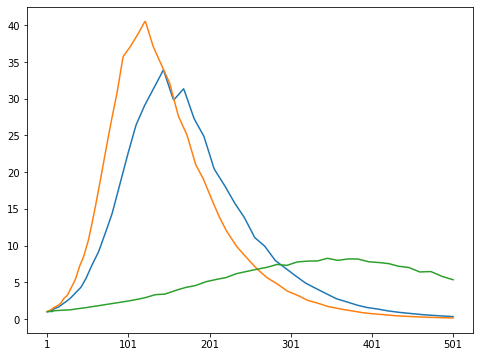

In [7]:
dfInfected.loc[1,:].plot()
dfInfected.loc[5,:].plot()
dfInfected.loc[9,:].plot()

We define a 90% / 10% of data for training / testing.

In [8]:
dfInfected_arr = dfInfected.values
dfInfected_arr.shape
TRAIN_SPLIT = int(dfInfected_arr.shape[0]-dfInfected_arr.shape[0]*0.1)
TRAIN_SPLIT

135

We standardize the data.

In [9]:
uni_train_mean = dfInfected_arr[:TRAIN_SPLIT].mean()
uni_train_std = dfInfected_arr[:TRAIN_SPLIT].std()
uni_data = (dfInfected_arr-uni_train_mean)/uni_train_std

We split the data into time series of `univariate_past_history=20` days length and predict the future of the current day, i.e., `univariate_future_target=0`, for the "infected" variable. 

In [10]:
def univariate_data(dataset, start_series, end_series, history_size, target_size):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0]) - target_size   
    for c in range(start_series, end_series):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i)
            # Reshape data from (history_size,) to (history_size, 1)
            data.append(np.reshape(dataset[c][indices], (history_size, 1)))
            labels.append(dataset[c][i+target_size])
    return np.array(data), np.array(labels)

In [11]:
univariate_past_history = 20 #days
univariate_future_target = 0 #current day

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, len(uni_data),
                                       univariate_past_history,
                                       univariate_future_target)

In [12]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target number to predict')
print (y_train_uni[0])
print ('\n Number of traing data points')
print (y_train_uni.shape[0])
print ('\n Number of test data points')
print (x_val_uni.shape[0])

Single window of past history
[[-0.95291296]
 [-0.95044298]
 [-0.94499366]
 [-0.9402021 ]
 [-0.93751136]
 [-0.93827393]
 [-0.93332191]
 [-0.92398652]
 [-0.91523643]
 [-0.90667772]
 [-0.90243571]
 [-0.89846308]
 [-0.89449045]
 [-0.89051782]
 [-0.88593997]
 [-0.87701137]
 [-0.86808277]
 [-0.85915417]
 [-0.85022557]
 [-0.84167481]]

 Target number to predict
-0.8339932964893617

 Number of traing data points
64935

 Number of test data points
7215


In [13]:
def create_time_steps(length):
    return list(range(-length, 0))

In [14]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/Users/wlomsi/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

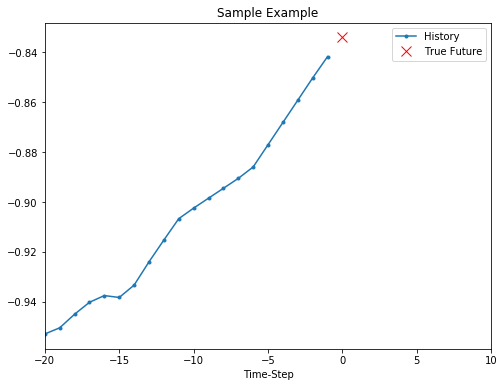

In [15]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

## Baseline forecasting

Predicts the mean of the `history`.

In [16]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/wlomsi/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

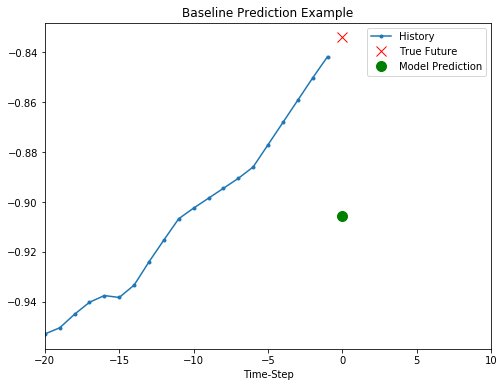

In [17]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

## Univariate LSTM based forecasting

Batching and resampling; the dataset is repeated indefinitely. Check the tutorial for the details.

In [22]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

train_univariate

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

We define the first LSTM model with 8 units.

In [33]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
simple_lstm_model.summary()
x_train_uni.shape[-2:]

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 8)                 320       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


(20, 1)

In [37]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)
    print(y.shape)

(256, 1)
(256,)


When passing an indefinitely repeated training data set, we need to specify the numbre of steps per training interval (epoch).

In [42]:
EVALUATION_INTERVAL = 2000
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 2000 steps, validate for 50 steps
Epoch 1/10
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 2/10
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 3/10
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 4/10
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/10
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 6/10
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 7/10
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/10
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/10
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 10/10
2000/2000 [======

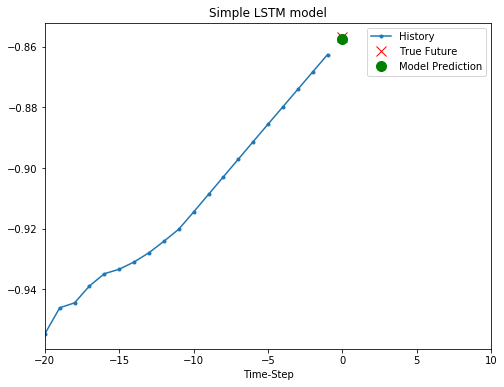

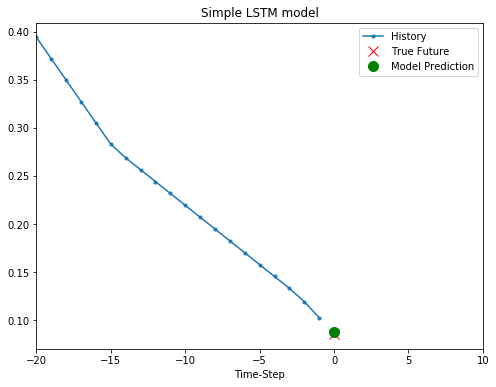

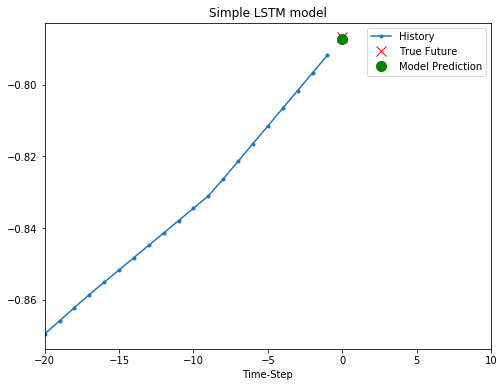

In [43]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

## Multivariate LSTM based forecasting - Single Step

We use three variables "Infected", "Recovered", and "Decased", to forcast "Infected" at one single day in the future.

Here a plot of the time series of the three variables for one outbreak. 

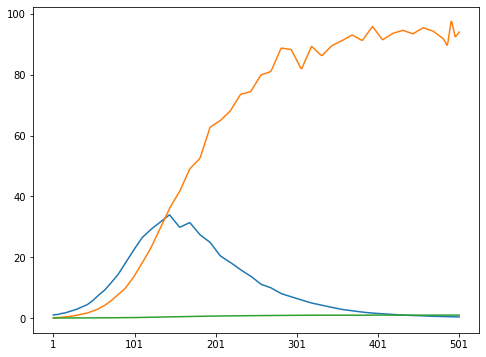

In [44]:
dfInfected.loc[1,:].plot()
dfRecovered.loc[2,:].plot()
dfDead.loc[3,:].plot()
dfInfected = dfInfected.values
dfRecovered_arr = dfRecovered.values
dfDead_arr = dfDead.values

We prepare the dataset.

In [46]:
#as before
dfInfected_train_mean = dfInfected_arr[:TRAIN_SPLIT].mean()
dfInfected_train_std = dfInfected_arr[:TRAIN_SPLIT].std()
dfInfected_data = (dfInfected_arr-dfInfected_train_mean)/dfInfected_train_std
#for Recovered
dfRecovered_train_mean = dfRecovered_arr[:TRAIN_SPLIT].mean()
dfRecovered_train_std = dfRecovered_arr[:TRAIN_SPLIT].std()
dfRecovered_data = (dfRecovered_arr-dfRecovered_train_mean)/dfRecovered_train_std
#for Dead
dfDead_train_mean = dfDead_arr[:TRAIN_SPLIT].mean()
dfDead_train_std = dfDead_arr[:TRAIN_SPLIT].std()
dfDead_data = (dfDead_arr-dfDead_train_mean)/dfDead_train_std

In [47]:
dataset = np.array([dfInfected_data, dfRecovered_data, dfDead_data])
dataset.shape

(3, 150, 501)

In [48]:
def multivariate_data(dataset, target, start_series, end_series, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0]) - target_size   
    for c in range(start_series, end_series):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            one = dataset[0][c][indices]
            two = dataset[1][c][indices]
            three = dataset[2][c][indices]
            data.append(np.transpose(np.array([one, two, three])))
            
            if single_step:
                labels.append(target[c][i+target_size])
            else:
                labels.append(np.transpose(target[c][i:i+target_size]))
    return np.array(data), np.array(labels)

We get training and valdation data for time series with a `past_history = 20` days for every other day (`STEP = 2`) and want to predict the "Infected" five days ahead (`future_target = 5`).

In [49]:
past_history = 20
future_target = 5
STEP = 2

x_train_single, y_train_single = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                               past_history, future_target, STEP,
                                               single_step=True)

In [50]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (10, 3)


As before, batching and resampling; the dataset is repeated indefinitely.

In [51]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [54]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.summary()
x_train_single.shape[-2:]

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 32)                4608      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


(10, 3)

In [55]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)
print ('\n Number of traing data points')
print (x_train_single.shape[0])
print ('\n Number of test data points')
print (x_val_single.shape[0])

(256, 1)

 Number of traing data points
16875

 Number of test data points
1875


In [56]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 2000 steps, validate for 50 steps
Epoch 1/10
2000/2000 [==============================] - 12s 6ms/step - loss: 0.0634 - val_loss: 0.0292
Epoch 2/10
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0343 - val_loss: 0.0263
Epoch 3/10
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0292 - val_loss: 0.0220
Epoch 4/10
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0267 - val_loss: 0.0230
Epoch 5/10
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0252 - val_loss: 0.0212
Epoch 6/10
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0242 - val_loss: 0.0194
Epoch 7/10
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0236 - val_loss: 0.0195
Epoch 8/10
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0231 - val_loss: 0.0180
Epoch 9/10
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0227 - val_loss: 0.0196
Epoch 10/10
2000/2000 [======

In [57]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

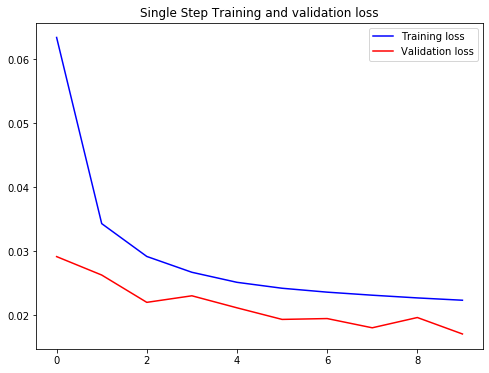

In [58]:
plot_train_history(single_step_history,'Single Step Training and validation loss')

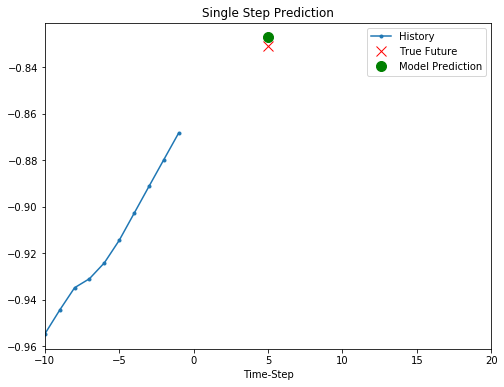

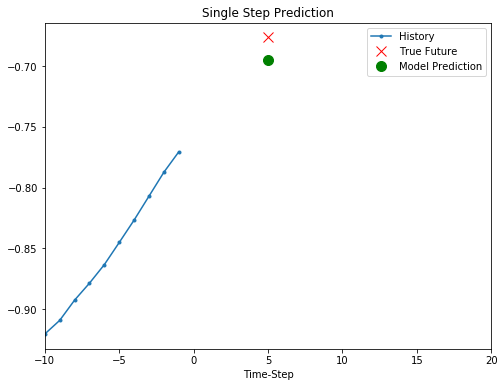

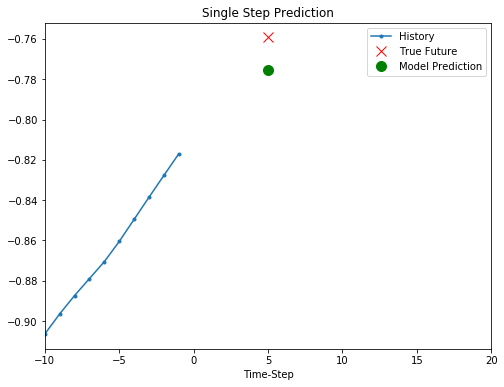

In [60]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], future_target,
                   'Single Step Prediction')
    plot.show()

## Multivariate LSTM - Multiple Steps

Still, we use a series of observed values of the three variables "Infected", "Recovered", and "Decased" (`past_history = 40, STEP =2`), but now to forcast the "Infected" values for a series day in the future (`future_target = 10`).

In [73]:
past_history = 40
future_target = 10
STEP =2
x_train_multi, y_train_multi = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                    past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                                past_history, future_target, STEP)

In [74]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\nTarget window to predict : {}'.format(y_train_multi[0].shape))
print ('\nNumber of traing data points: {}'.format(x_train_multi.shape[0]))
print ('\nNumber of test data points: {}'.format(x_val_multi.shape[0]))

Single window of past history : (20, 3)

Target window to predict : (10,)

Number of traing data points: 13500

Number of test data points: 1500


As before, batching and resampling; the dataset is repeated indefinitely.

In [75]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [77]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

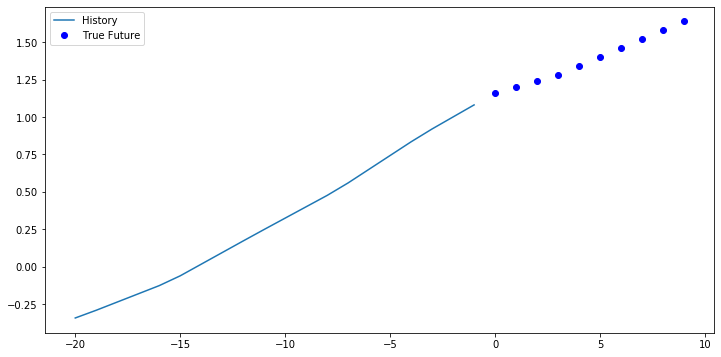

In [78]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Now we bild a model with two LSTM layers.

In [82]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model.summary()
x_train_multi.shape[-2:]

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 20, 32)            4608      
_________________________________________________________________
lstm_21 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_17 (Dense)             (None, 10)                170       
Total params: 7,914
Trainable params: 7,914
Non-trainable params: 0
_________________________________________________________________


(20, 3)

In [83]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 10)


The training time is longer for this more complex model.

In [84]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 2000 steps, validate for 50 steps
Epoch 1/10
2000/2000 [==============================] - 36s 18ms/step - loss: 0.1000 - val_loss: 0.0403
Epoch 2/10
2000/2000 [==============================] - 31s 15ms/step - loss: 0.0455 - val_loss: 0.0275
Epoch 3/10
2000/2000 [==============================] - 32s 16ms/step - loss: 0.0376 - val_loss: 0.0274
Epoch 4/10
2000/2000 [==============================] - 33s 16ms/step - loss: 0.0332 - val_loss: 0.0237
Epoch 5/10
2000/2000 [==============================] - 31s 16ms/step - loss: 0.0306 - val_loss: 0.0240
Epoch 6/10
2000/2000 [==============================] - 30s 15ms/step - loss: 0.0288 - val_loss: 0.0232
Epoch 7/10
2000/2000 [==============================] - 31s 15ms/step - loss: 0.0275 - val_loss: 0.0223
Epoch 8/10
2000/2000 [==============================] - 32s 16ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 9/10
2000/2000 [==============================] - 31s 16ms/step - loss: 0.0258 - val_loss: 0.0222
Epoch 10/10
2000/200

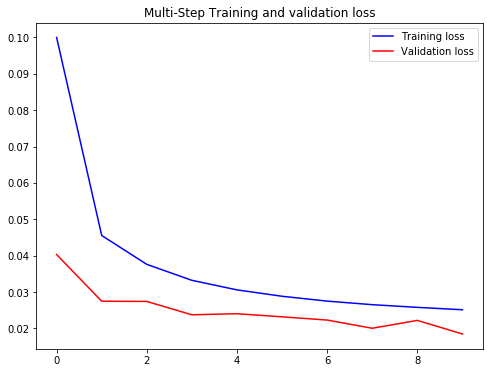

In [85]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

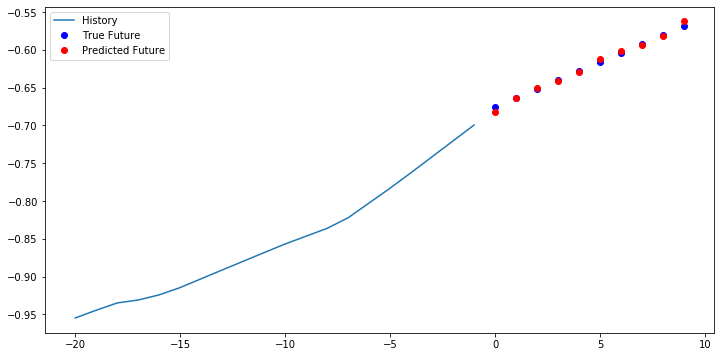

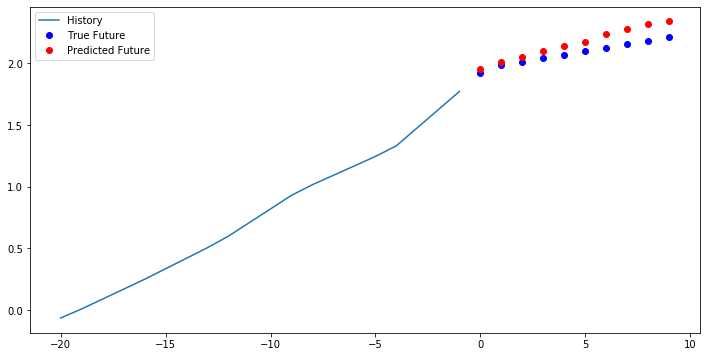

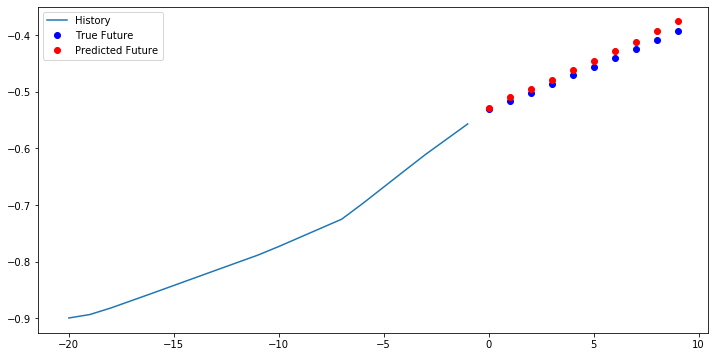

In [86]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])